In [200]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

In [201]:
data = pd.read_csv('/workspaces/wiggle-face/data/panda_each_video/panda_features_updated_to_be_labeled.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448436 entries, 0 to 448435
Data columns (total 33 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   infant_id                                             448436 non-null  int64  
 1   date                                                  448436 non-null  int64  
 2   cam                                                   448436 non-null  int64  
 3   frame_id                                              448436 non-null  int64  
 4   right_brow_mean_y                                     448436 non-null  float64
 5   left_brow_mean_y                                      448436 non-null  float64
 6   right_eye_distance                                    448436 non-null  float64
 7   left_eye_distance                                     448436 non-null  float64
 8   lips_distance                               

In [202]:
def remove_outliers(column):
    mean = column.mean()
    std = column.std()
    return column[(column >= mean - 3 * std) & (column <= mean + 3 * std)]

# Define the conditions
conditions = (data['right_brow_mean_y'] >= 0.3) & (data['left_brow_mean_y'] >= 0.3)
eye_width_condition = abs(data['right_eye_width'] - data['left_eye_width']) <= 0.2
eyebrow_width_condition = abs(data['right_eyebrow_width'] - data['left_eyebrow_width']) <= 0.3

# Apply the conditions to filter the rows
filtered_data = data[eye_width_condition & eyebrow_width_condition & conditions].copy()

# Remove outliers for specific columns
filtered_data.loc[:, 'right_eye_width'] = remove_outliers(filtered_data['right_eye_width'])
filtered_data.loc[:, 'left_eye_width'] = remove_outliers(filtered_data['left_eye_width'])
filtered_data.loc[:, 'right_eyebrow_width'] = remove_outliers(filtered_data['right_eyebrow_width'])
filtered_data.loc[:, 'left_eyebrow_width'] = remove_outliers(filtered_data['left_eyebrow_width'])

# Drop rows with NaNs and reset the index
filtered_data.dropna(inplace=True)
filtered_data.reset_index(drop=True, inplace=True)

# Display the DataFrame information
filtered_data.info()

# Display the first few rows of the cleaned DataFrame
print(filtered_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230613 entries, 0 to 230612
Data columns (total 33 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   infant_id                                             230613 non-null  int64  
 1   date                                                  230613 non-null  int64  
 2   cam                                                   230613 non-null  int64  
 3   frame_id                                              230613 non-null  int64  
 4   right_brow_mean_y                                     230613 non-null  float64
 5   left_brow_mean_y                                      230613 non-null  float64
 6   right_eye_distance                                    230613 non-null  float64
 7   left_eye_distance                                     230613 non-null  float64
 8   lips_distance                               

In [203]:
filtered_data.drop(columns=['nose_centre_lips_centre_dist'], inplace=True)
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230613 entries, 0 to 230612
Data columns (total 32 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   infant_id                                             230613 non-null  int64  
 1   date                                                  230613 non-null  int64  
 2   cam                                                   230613 non-null  int64  
 3   frame_id                                              230613 non-null  int64  
 4   right_brow_mean_y                                     230613 non-null  float64
 5   left_brow_mean_y                                      230613 non-null  float64
 6   right_eye_distance                                    230613 non-null  float64
 7   left_eye_distance                                     230613 non-null  float64
 8   lips_distance                               

In [204]:
import cv2
def process_infant_id(infant_id):
    infant_id_str = str(int(infant_id))
    if len(infant_id_str) == 1:
        return '00' + infant_id_str
    elif len(infant_id_str) == 2:
        return '0' + infant_id_str
    else:
        return infant_id_str[-3:]

# Function to get the frame from the video
def get_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Failed to extract frame {frame_number} from {video_path}")
        return None
    
# function to display a selected row
def display_row_panda_1_3(row_index, video_folder):
    if row_index < 0 or row_index >= len(filtered_data):
        print("Invalid row index")
        return
    
    row = filtered_data.iloc[row_index]
    infant_id = process_infant_id(row['infant_id'])
    frame_id = int(row['frame_id'])
    date_id = pd.to_datetime(row['date'], unit='D')
    date_id = date_id.strftime('%Y_%m_%d')
    #emotion = row['cluster']
    cam_id = int(row['cam'])
    
    # video file path
    video_filename = f'r_{date_id}_833180_{infant_id}_cam{cam_id}_vid4.mp4'
    video_path = f'{video_folder}/{video_filename}'
    
    # get the frame
    frame = get_frame(video_path, frame_id)
    
    if frame is not None:
        plt.figure(figsize=(10, 6))
        plt.imshow(frame)
        plt.title(f'Video: {video_filename}, Frame:{frame_id}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Frame {frame_id} could not be retrieved from {video_filename}")

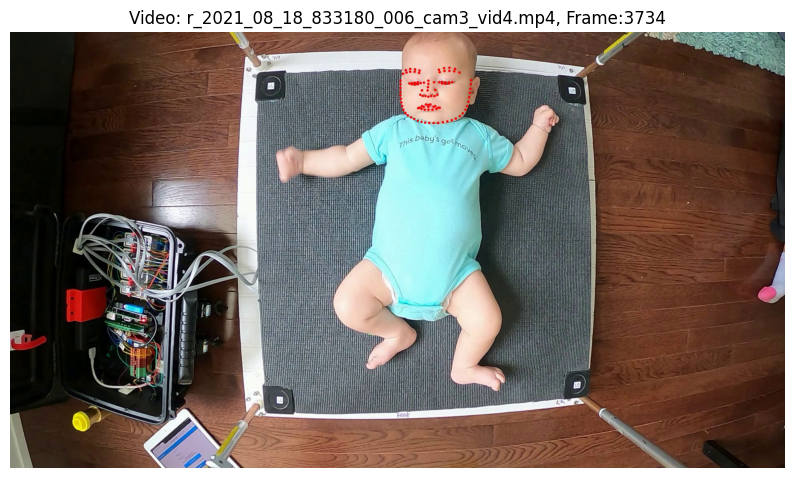

In [310]:
video_folder_panda_1 = '/workspaces/wiggle-face/data-ioana/PANDA1/r_face_infant_visible/vis'
video_folder_panda_3 = '/workspaces/wiggle-face/data-ioana/PANDA3/face/vis'
display_row_panda_1_3(6100, video_folder_panda_1)

In [23]:
# Add an empty 'emotion' column to the filtered data
filtered_data['emotion'] = ''
def label_emotion(data, start_index, emotion):
    end_index = min(start_index + 100, len(data))
    data.loc[start_index:end_index, 'emotion'] = emotion
    return data

In [75]:
# label 'neutral', 'positive', 'negative', 'positive-neutral', 'negative-neutral'
start_index = 1030
emotion = 'negative-neutral'
filtered_data = label_emotion(filtered_data, start_index, emotion)

In [77]:
filtered_data.to_csv('dataset_for_labeling.csv')